In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from pandas_datareader.data import DataReader
import torch

In [2]:
def plot(prediction,target,grey=None,start=None,end=None):
    # if start is None:
    #     start=df.index.min()
    # if end is None:
    #     end=df.index.max()
    # recessions=DataReader('USREC', 'fred', start=start,end=end)['USREC']

    # pd.concat([,target],axis=1,ignore_index=False).plot()
    fig, ax = plt.subplots(figsize=(10, 3), dpi=300)
    
    # if isinstance(df,pd.DataFrame):
    # else:
    #     ylim = (df.min(),df.max())
        

    Results=pd.DataFrame(prediction,index=target.index)
    Results.plot(ax=ax,legend=True)
    Results['target']=target
    ylim = (Results.min().min(),Results.max().max())
    ax.fill_between(Results['target'].index, 0, ylim[1]+1e-2, Results['target'],facecolor='k', alpha=0.1)
    ax.legend(["Prediction", "NBER recession indicator"])
    return fig,ax

In [3]:
# df=yf.download("GE")
# df.head()
n_lookback=30
n_forecast=1

df=pd.read_csv('Data/Transformed HistoricalVariables.csv',index_col=0,parse_dates=True)
recessions =  DataReader('USREC', 'fred', start='1800')
df[f'in a recession']=recessions
df['target'] = recessions.shift(-12)

df.fillna(method='ffill',inplace=True)
# df=df.fillna(-1)
df=df['1971':] #.resample('M').last()
print(df.shape)
df.head()

(11070, 126)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RSXFS,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,UMCSENT,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST,S&P: indust,S&P div yield,S&P PE ratio,in a recession,target
1971-01-01,0.008594,0.0096,0.013628,0.00975,NaN,0.007663,0.003694,0.003908,0.014828,0.039006,...,0.0,0.007963,-0.003878,-0.00768,0.023135,NaN,0.0,0.031962,0.0,0.0
1971-01-02,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,-0.007963,0.003878,0.00768,-0.023135,NaN,0.0,0.000000,0.0,0.0
1971-01-09,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-16,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0
1971-01-23,0.000000,0.0000,0.000000,0.00000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.00000,0.000000,NaN,0.0,0.000000,0.0,0.0


In [4]:
test_split=round(len(df)*0.20)
df_for_training=df[:"2004"]
df_for_testing=df["2004":"2021"]
print('df_for_training shape: ',df_for_training.shape)
print('df_for_testing shape: ',df_for_testing.shape)

df_for_training shape:  (5292, 126)
df_for_testing shape:  (5698, 126)


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training.fillna(0))
# df_for_training_scaled[np.isnan(df_for_training_scaled)] = -1
df_for_testing_scaled=scaler.transform(df_for_testing.fillna(0))
# df_for_testing_scaled[np.isnan(df_for_testing_scaled)] = -1


In [6]:
def createXY(dataset,n_lookback = 30,n_forecast = 1,target_col=-1):
    X = []
    Y = []

    for i in range(n_lookback, len(dataset) - n_forecast + 1):
        X.append(dataset[i - n_lookback: i, 0:max(1,dataset.shape[1]-1)])
        Y.append(dataset[i: i + n_forecast,target_col])

    return torch.tensor(X),torch.tensor(Y)



In [7]:
trainX,trainY=createXY(df_for_training_scaled,n_lookback=n_lookback,n_forecast=n_forecast)
testX,testY=createXY(df_for_testing_scaled,n_lookback=n_lookback,n_forecast=n_forecast)

C:\Users\amine\AppData\Local\Temp\ipykernel_19032\3481123690.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X),torch.tensor(Y)


# trying pytorch

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import yfinance as yf

df = yf.download('AAPL')
timeseries = df[["Adj Close"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]


[*********************100%***********************]  1 of 1 completed


In [9]:
def create_dataset(dataset, lookback,n_forecast=1):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(n_lookback,len(dataset)-n_forecast):
        feature = dataset[i - n_lookback: i]
        target = dataset[i+1:i+n_forecast+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))


In [10]:

lookback = 5
# X_train, y_train = create_dataset(train, lookback=lookback)
# X_test, y_test = create_dataset(test, lookback=lookback)
X_train, y_train = createXY(train, n_lookback=lookback,n_forecast=1,target_col=0)
X_test, y_test = createXY(test, n_lookback=lookback,n_forecast=1,target_col=0)


In [11]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units)

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  # First dim of Hn is num_layers, which is set to 1 above.
        # print(out.shape)
        return out


In [12]:

model = ShallowRegressionLSTM(num_sensors=1, hidden_units=8)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)


In [13]:
to_plot=[]
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    to_plot.append((epoch, train_rmse, test_rmse))
    if epoch % 10 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

NameError: name 'train_rmse' is not defined

In [ ]:

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[:X_train.shape[0]] = model(X_train) #[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[X_train.shape[0]+lookback:X_train.shape[0]+lookback+X_test.shape[0]] = model(X_test) #[:, -1, :]


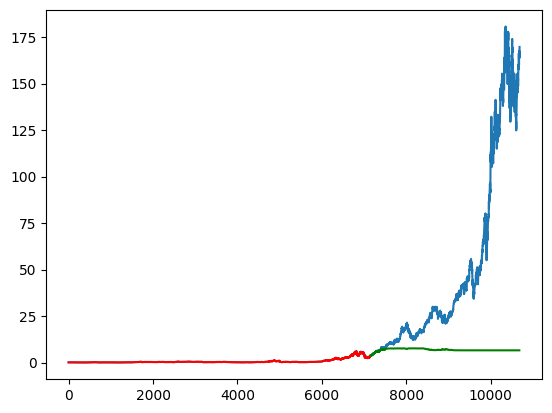

In [ ]:
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

# Multivatrite


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output



In [ ]:
# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Define hyperparameters
input_dim = X_train.shape[2]  # Number of input features
hidden_dim = 32  # Number of hidden units in the LSTM layer
output_dim = 1  # Number of output dimensions (binary target)
num_epochs = 100
learning_rate = 0.01



NameError: name 'X_train' is not defined

In [ ]:
# Initialize the LSTM model
model = LSTM(input_dim, hidden_dim, output_dim)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [ ]:
# Training loop
for epoch in range(num_epochs):
    inputs = Variable(X_train.float())  # Convert inputs to float
    targets = Variable(y_train.float().view(-1))  # Reshape targets to match the output shape
    
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs.squeeze(), targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))




Epoch [10/100], Loss: -11.5278
Epoch [20/100], Loss: -12.5626
Epoch [30/100], Loss: -13.5922
Epoch [40/100], Loss: -14.6173
Epoch [50/100], Loss: -15.6369
Epoch [60/100], Loss: -16.6568
Epoch [70/100], Loss: -17.6722
Epoch [80/100], Loss: -18.6852
Epoch [90/100], Loss: -19.6962
Epoch [100/100], Loss: -20.7049


In [ ]:
# Make predictions
model.eval()
with torch.no_grad():
    inputs = Variable(X_test.float())  # Convert test inputs to float
    predictions = model(inputs)



In [ ]:
# Convert predictions and ground truth to numpy arrays
predictions = (torch.sigmoid(predictions) >= 0.5).float().numpy()


(<Figure size 3000x900 with 1 Axes>, <Axes: >)

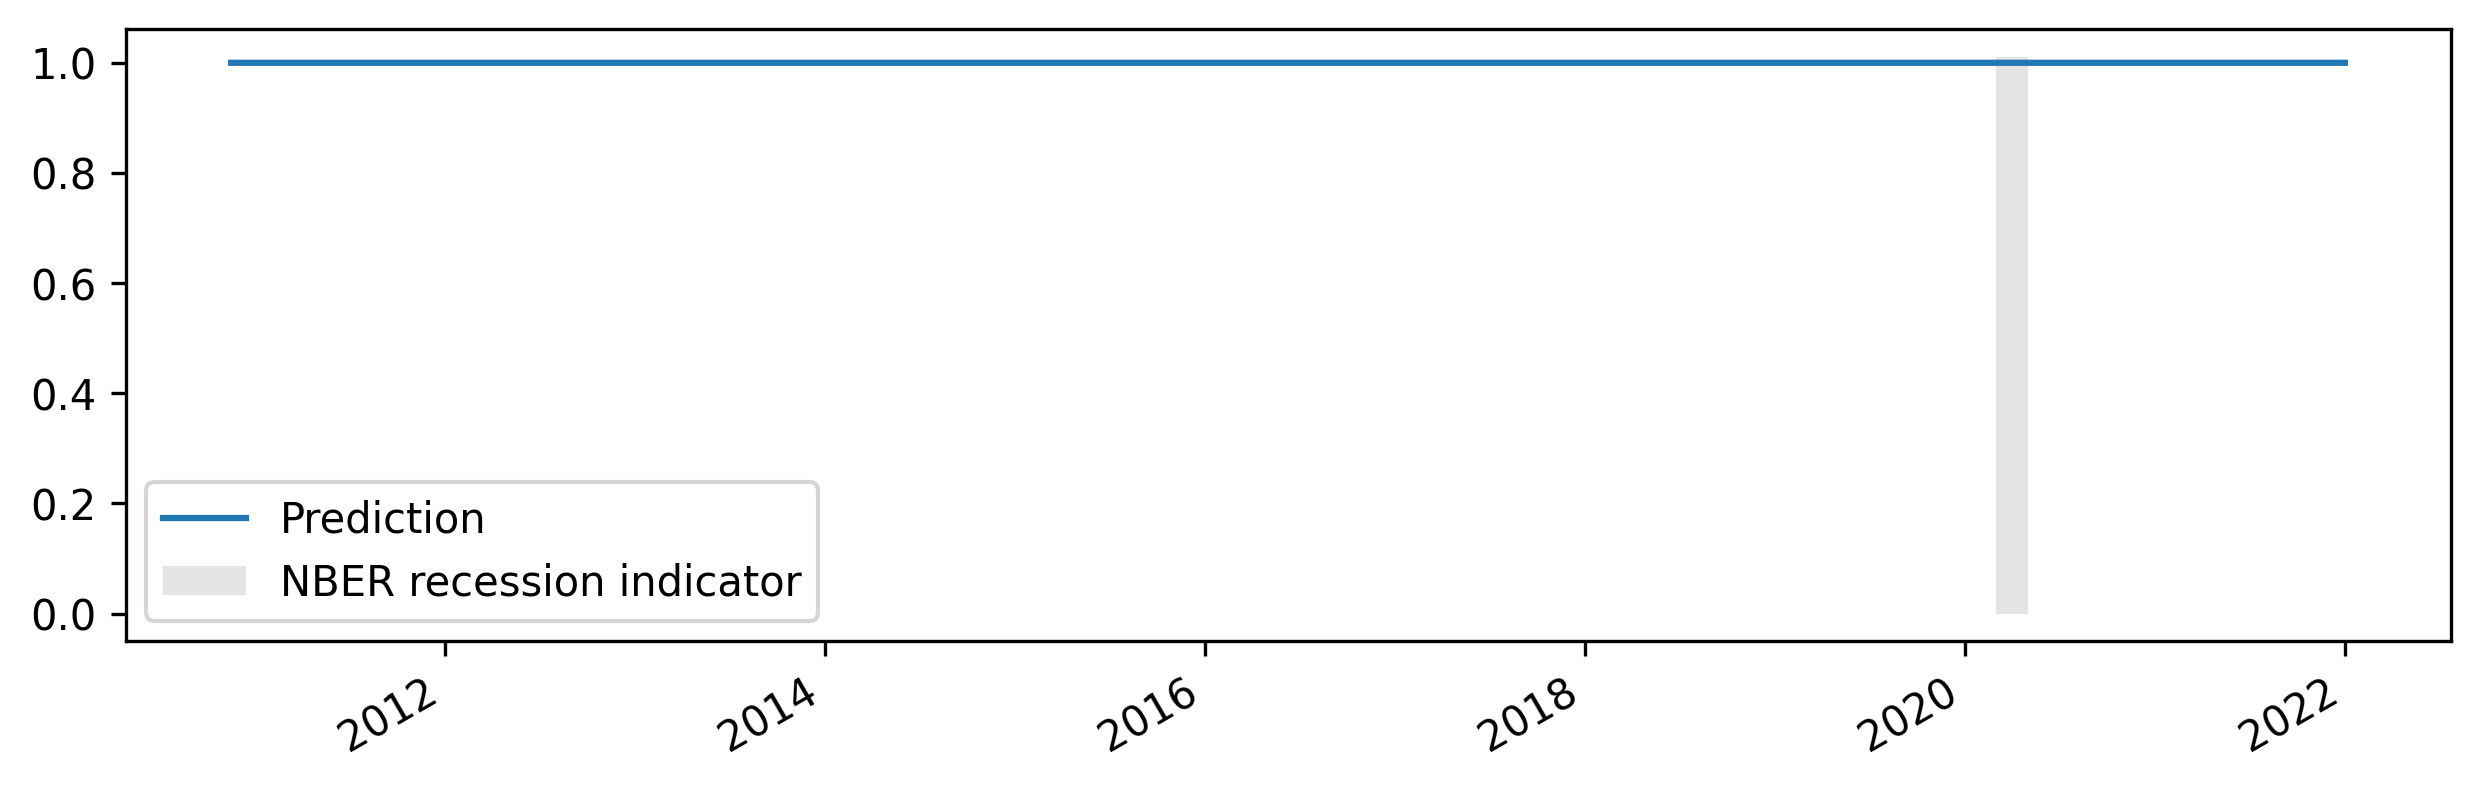

In [ ]:
plot(predictions,df_for_testing.iloc[-predictions.shape[0]:,-2])


# code


In [ ]:

df = pd.read_csv('BTC-USD.csv', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

In [ ]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Bitcoin price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();

In [ ]:
X, y = df.drop(columns=['Close']), df.Close.values
X.shape, y.shape

In [ ]:

from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

In [ ]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 50)
print(X_ss.shape, y_mm.shape)


In [ ]:
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()


In [16]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the model checkpoint
# f = {'filepath': 'Model/CNN2-LSTM', 'monitor': 'recall', 'mode': 'max', 'verbose': 1, 'save_best_only': True}
# model_checkpoint = ModelCheckpoint(**f)

# Define the model architecture
class MyModel(nn.Module):
    def __init__(self, n_features, n_forecast):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n_features, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool1d(kernel_size=1)
        self.dropout = nn.Dropout(p=0.1)
        self.flatten = nn.Flatten()
        self.repeat = nn.Repeat(1, 1)
        self.lstm = nn.LSTM(input_size=32, hidden_size=100, num_layers=1, batch_first=True)
        self.fc = nn.Linear(in_features=100, out_features=n_forecast)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.repeat(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# Create the model instance
model = MyModel(trainX.shape[2], n_forecast).to(device)

# Print the model summary
print(model)



ModuleNotFoundError: No module named 'torch.tensor'